In [22]:
# import libraries
from datetime import datetime
import re
import glob
import requests 
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from os import getcwd

In [23]:
# get data
link = 'https://www.mohfw.gov.in/'
req = requests.get(link)
soup = BeautifulSoup(req.content, "html.parser")  

# Data processing
thead = soup.find_all('thead')[-1]
head = thead.find_all('tr')
tbody = soup.find_all('tbody')[-1]
body = tbody.find_all('tr')

In [24]:
head_rows = []
body_rows = []

# append each row to head
for tr in head:
    td = tr.find_all(['th', 'td'])
    row = [i.text for i in td]
    head_rows.append(row)
#append each row to body
for tr in body:
    td = tr.find_all(['th', 'td'])
    row = [i.text for i in td]
    body_rows.append(row)

In [25]:
#convert into DataFrame and Date column
df1 = pd.DataFrame(body_rows[:len(body_rows)-6], columns=head_rows[0])         
df1.drop('S. No.', axis=1, inplace=True)

now  = datetime.now()
df1['Date'] = now.strftime("%m/%d/%Y") 
df1['Date'] = pd.to_datetime(df1['Date'], format='%m/%d/%Y')

# remove extra characters from 'Name of State/UT' column
df1['Name of State / UT'] = df1['Name of State / UT'].str.replace('#', '')

df1.head(36)     #there are 36 states in india

,Name of State / UT,Active Cases*,Cured/Discharged/Migrated*,Deaths**,Total Confirmed cases*,Date
0,Andaman and Nicobar Islands,0,33,0,33,2020-06-02
1,Andhra Pradesh,1341,2378,64,3783,2020-06-02
2,Arunachal Pradesh,21,1,0,22,2020-06-02
3,Assam,1109,277,4,1390,2020-06-02
4,Bihar,2002,1900,24,3926,2020-06-02
5,Chandigarh,91,199,4,294,2020-06-02
6,Chhattisgarh,424,122,1,547,2020-06-02
7,Dadar Nagar Haveli,2,1,0,3,2020-06-02
8,Delhi,11565,8746,523,20834,2020-06-02
9,Goa,29,42,0,71,2020-06-02


In [26]:
df1["Deaths**"]=df1["Deaths**"].astype(int)
df1["Cured/Discharged/Migrated*"]=df1["Cured/Discharged/Migrated*"].astype(int)
df1["Total Confirmed cases*"]=df1["Total Confirmed cases*"].astype(int)
df1["Death_percentage"] = ((df1["Deaths**"])/(df1["Total Confirmed cases*"]))*100
df1["Cured_percentage"]=(df1["Cured/Discharged/Migrated*"]/df1["Total Confirmed cases*"])*100

In [27]:
# latitude and longitude
lat = {'Delhi':28.7041, 'Haryana':29.0588, 'Kerala':10.8505, 'Rajasthan':27.0238,
       'Telengana':18.1124, 'Uttar Pradesh':26.8467, 'Ladakh':34.2996, 'Tamil Nadu':11.1271,
       'Jammu and Kashmir':33.7782, 'Punjab':31.1471, 'Karnataka':15.3173, 'Maharashtra':19.7515,
       'Andhra Pradesh':15.9129, 'Odisha':20.9517, 'Uttarakhand':30.0668, 'West Bengal':22.9868, 
       'Puducherry': 11.9416, 'Chandigarh': 30.7333, 'Chhattisgarh':21.2787, 'Gujarat': 22.2587, 
       'Himachal Pradesh': 31.1048, 'Madhya Pradesh': 22.9734, 'Bihar': 25.0961, 'Manipur':24.6637, 
       'Mizoram':23.1645, 'Goa': 15.2993, 'Andaman and Nicobar Islands': 11.7401, 'Assam' : 26.2006, 
       'Jharkhand': 23.6102, 'Arunachal Pradesh': 28.2180, 'Tripura': 23.9408, 'Nagaland': 26.1584, 
       'Meghalaya' : 25.4670, 'Dadar Nagar Haveli' : 20.1809 , 'Sikkim': 27.5712}

long = {'Delhi':77.1025, 'Haryana':76.0856, 'Kerala':76.2711, 'Rajasthan':74.2179,
        'Telengana':79.0193, 'Uttar Pradesh':80.9462, 'Ladakh':78.2932, 'Tamil Nadu':78.6569,
        'Jammu and Kashmir':76.5762, 'Punjab':75.3412, 'Karnataka':75.7139, 'Maharashtra':75.7139,
        'Andhra Pradesh':79.7400, 'Odisha':85.0985, 'Uttarakhand':79.0193, 'West Bengal':87.8550, 
        'Puducherry': 79.8083, 'Chandigarh': 76.7794, 'Chhattisgarh':81.8661, 'Gujarat': 71.1924, 
        'Himachal Pradesh': 77.1734, 'Madhya Pradesh': 78.6569, 'Bihar': 85.3131, 'Manipur':93.9063, 
        'Mizoram':92.9376, 'Goa': 74.1240, 'Andaman and Nicobar Islands': 92.6586, 'Assam' : 92.9376, 
        'Jharkhand': 85.2799, 'Arunachal Pradesh': 94.7278, 'Tripura': 91.9882, 'Nagaland': 94.5624,
        'Meghalaya' : 91.3662, 'Dadar Nagar Haveli' : 73.0169,'Sikkim' : 88.4759}

# add latitude and longitude column based on 'Name of State / UT' column
df1['Latitude'] = df1['Name of State / UT'].map(lat)
df1['Longitude'] = df1['Name of State / UT'].map(long)


In [28]:
# Savind data in file, names as year-month-day.csv format
file_name = now.strftime("%Y_%m_%d")+'.csv'

# location for saving the file
file_loc = getcwd()
df1.to_csv(file_loc + file_name, index=False)

In [29]:
# location of the file
loc =  getcwd()
files = glob.glob(loc+'2020*.csv')
dfs = []

for i in files:
    df_temp = pd.read_csv(i)
    df_temp = df_temp.rename(columns={'Cured':'Cured/Discharged'})
    df_temp = df_temp.rename(columns={'Cured/Discharged':'Cured/Discharged/Migrated','Total Confirmed cases *': 'Total Confirmed cases', 
                                      'Total Confirmed cases ': 'Total Confirmed cases', 'Total Confirmed cases* ': 'Total Confirmed cases'})
    df_temp = df_temp.rename(columns=lambda x: re.sub('Total Confirmed cases \(Including .* foreign Nationals\) ','Total Confirmed cases',x))
    df_temp = df_temp.rename(columns={'Deaths ( more than 70% cases due to comorbidities )':'Death','Deaths**':'Death'})
    dfs.append(df_temp)

complete_data = pd.concat(dfs, ignore_index=True).sort_values(['Date'], ascending=True).reset_index(drop=True)

In [30]:
complete_data['Date'] = pd.to_datetime(complete_data['Date'])
complete_data = complete_data.sort_values(['Date', 'Name of State / UT']).reset_index(drop=True)
df_current = complete_data[-35:]
df_current.reset_index(drop=True,inplace=True)

In [31]:
df_current

,Name of State / UT,Active Cases*,Cured/Discharged/Migrated*,Death,Total Confirmed cases*,Date,Death_percentage,Cured_percentage,Latitude,Longitude
0,Andaman and Nicobar Islands,0,33,0,33,2020-06-02,0.000000,100.000000,11.7401,92.6586
1,Andhra Pradesh,1341,2378,64,3783,2020-06-02,1.691779,62.860164,15.9129,79.7400
2,Arunachal Pradesh,21,1,0,22,2020-06-02,0.000000,4.545455,28.2180,94.7278
3,Assam,1109,277,4,1390,2020-06-02,0.287770,19.928058,26.2006,92.9376
4,Bihar,2002,1900,24,3926,2020-06-02,0.611309,48.395313,25.0961,85.3131
5,Chandigarh,91,199,4,294,2020-06-02,1.360544,67.687075,30.7333,76.7794
6,Chhattisgarh,424,122,1,547,2020-06-02,0.182815,22.303473,21.2787,81.8661
7,Dadar Nagar Haveli,2,1,0,3,2020-06-02,0.000000,33.333333,20.1809,73.0169
8,Delhi,11565,8746,523,20834,2020-06-02,2.510320,41.979457,28.7041,77.1025
9,Goa,29,42,0,71,2020-06-02,0.000000,59.154930,15.2993,74.1240


In [34]:
Total_cases_in_India = df_current["Total Confirmed cases*"].sum()
Total_deaths_in_India = df_current['Death'].sum()
Total_cured_in_India = df_current["Cured/Discharged/Migrated*"].sum()
Cured_percentage = (Total_cured_in_India/Total_cases_in_India)*100
Death_percentage = (Total_deaths_in_India / Total_cases_in_India)*100

In [35]:
print("Total_cases_in_India : ",Total_cases_in_India)
print("Total_cured_in_India : ",Total_cured_in_India)
print("Total_deaths_in_India : ",Total_deaths_in_India)
print("Cured_percentage : ",Cured_percentage)
print("Death_percentage : ",Death_percentage)

Total_cases_in_India :  192292
Total_cured_in_India :  95527
Total_deaths_in_India :  5598
Cured_percentage :  49.678093732448566
Death_percentage :  2.9111975537203834


In [39]:
complete_data.to_csv('complete.csv', index=False)

# Data visiualization

In [41]:
complete_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 10 columns):
Name of State / UT            35 non-null object
Active Cases*                 35 non-null int64
Cured/Discharged/Migrated*    35 non-null int64
Death                         35 non-null int64
Total Confirmed cases*        35 non-null int64
Date                          35 non-null datetime64[ns]
Death_percentage              35 non-null float64
Cured_percentage              35 non-null float64
Latitude                      35 non-null float64
Longitude                     35 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(4), object(1)
memory usage: 2.8+ KB


# ##Statewise observation

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 <a list of 18 Text xticklabel objects>)

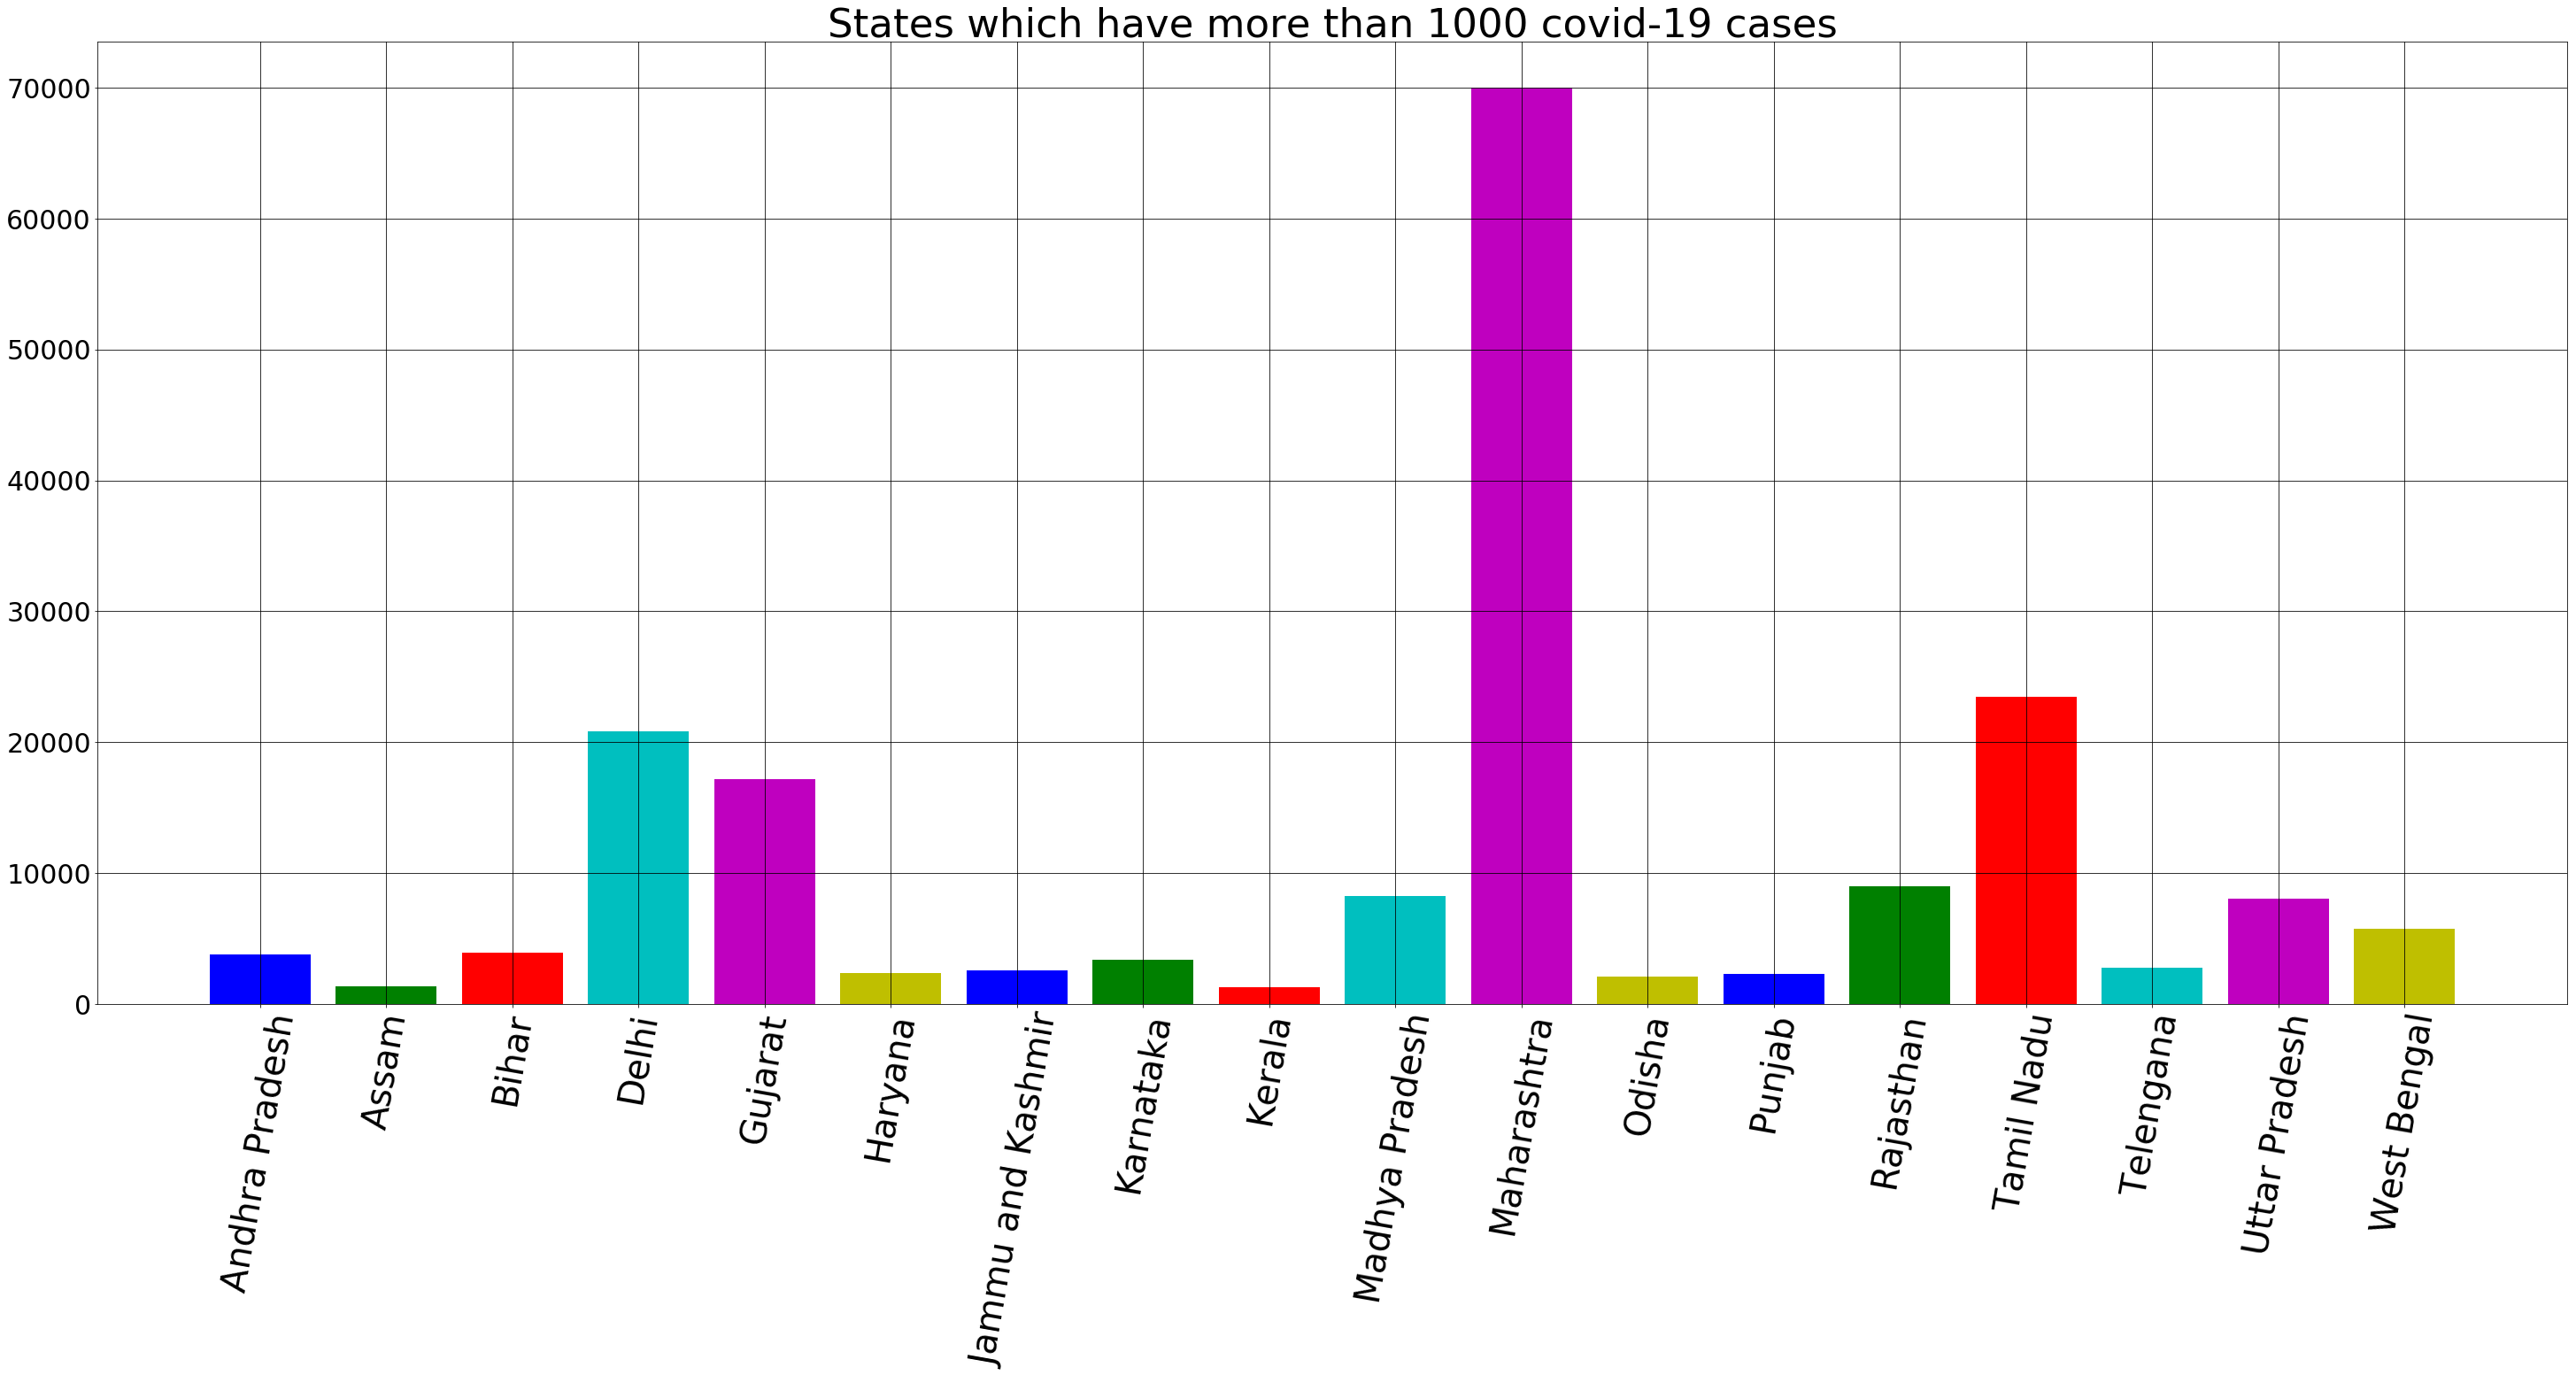

In [44]:
df_current_ava = df_current[df_current["Total Confirmed cases*"]>1000]
plt.figure(figsize=(50,20))
plt.title("States which have more than 1000 covid-19 cases",fontsize=45)
plt.bar(df_current_ava['Name of State / UT'],df_current_ava['Total Confirmed cases*'],color="bgrcmy")
plt.xticks(fontsize=40)
plt.yticks(fontsize=30)
plt.grid(color="k")
plt.xticks(rotation=80)

Most number of cases in states

In [46]:
df_current.sort_values(by=["Total Confirmed cases*"],ascending = False).reset_index(drop = True)

,Name of State / UT,Active Cases*,Cured/Discharged/Migrated*,Death,Total Confirmed cases*,Date,Death_percentage,Cured_percentage,Latitude,Longitude
0,Maharashtra,37543,30108,2362,70013,2020-06-02,3.373659,43.003442,19.7515,75.7139
1,Tamil Nadu,10141,13170,184,23495,2020-06-02,0.783145,56.054480,11.1271,78.6569
2,Delhi,11565,8746,523,20834,2020-06-02,2.510320,41.979457,28.7041,77.1025
3,Gujarat,5357,10780,1063,17200,2020-06-02,6.180233,62.674419,22.2587,71.1924
4,Rajasthan,2742,6040,198,8980,2020-06-02,2.204900,67.260579,27.0238,74.2179
5,Madhya Pradesh,2922,5003,358,8283,2020-06-02,4.322106,60.400821,22.9734,78.6569
6,Uttar Pradesh,3015,4843,217,8075,2020-06-02,2.687307,59.975232,26.8467,80.9462
7,West Bengal,3141,2306,325,5772,2020-06-02,5.630631,39.951490,22.9868,87.8550
8,Bihar,2002,1900,24,3926,2020-06-02,0.611309,48.395313,25.0961,85.3131
9,Andhra Pradesh,1341,2378,64,3783,2020-06-02,1.691779,62.860164,15.9129,79.7400


Deaths in states

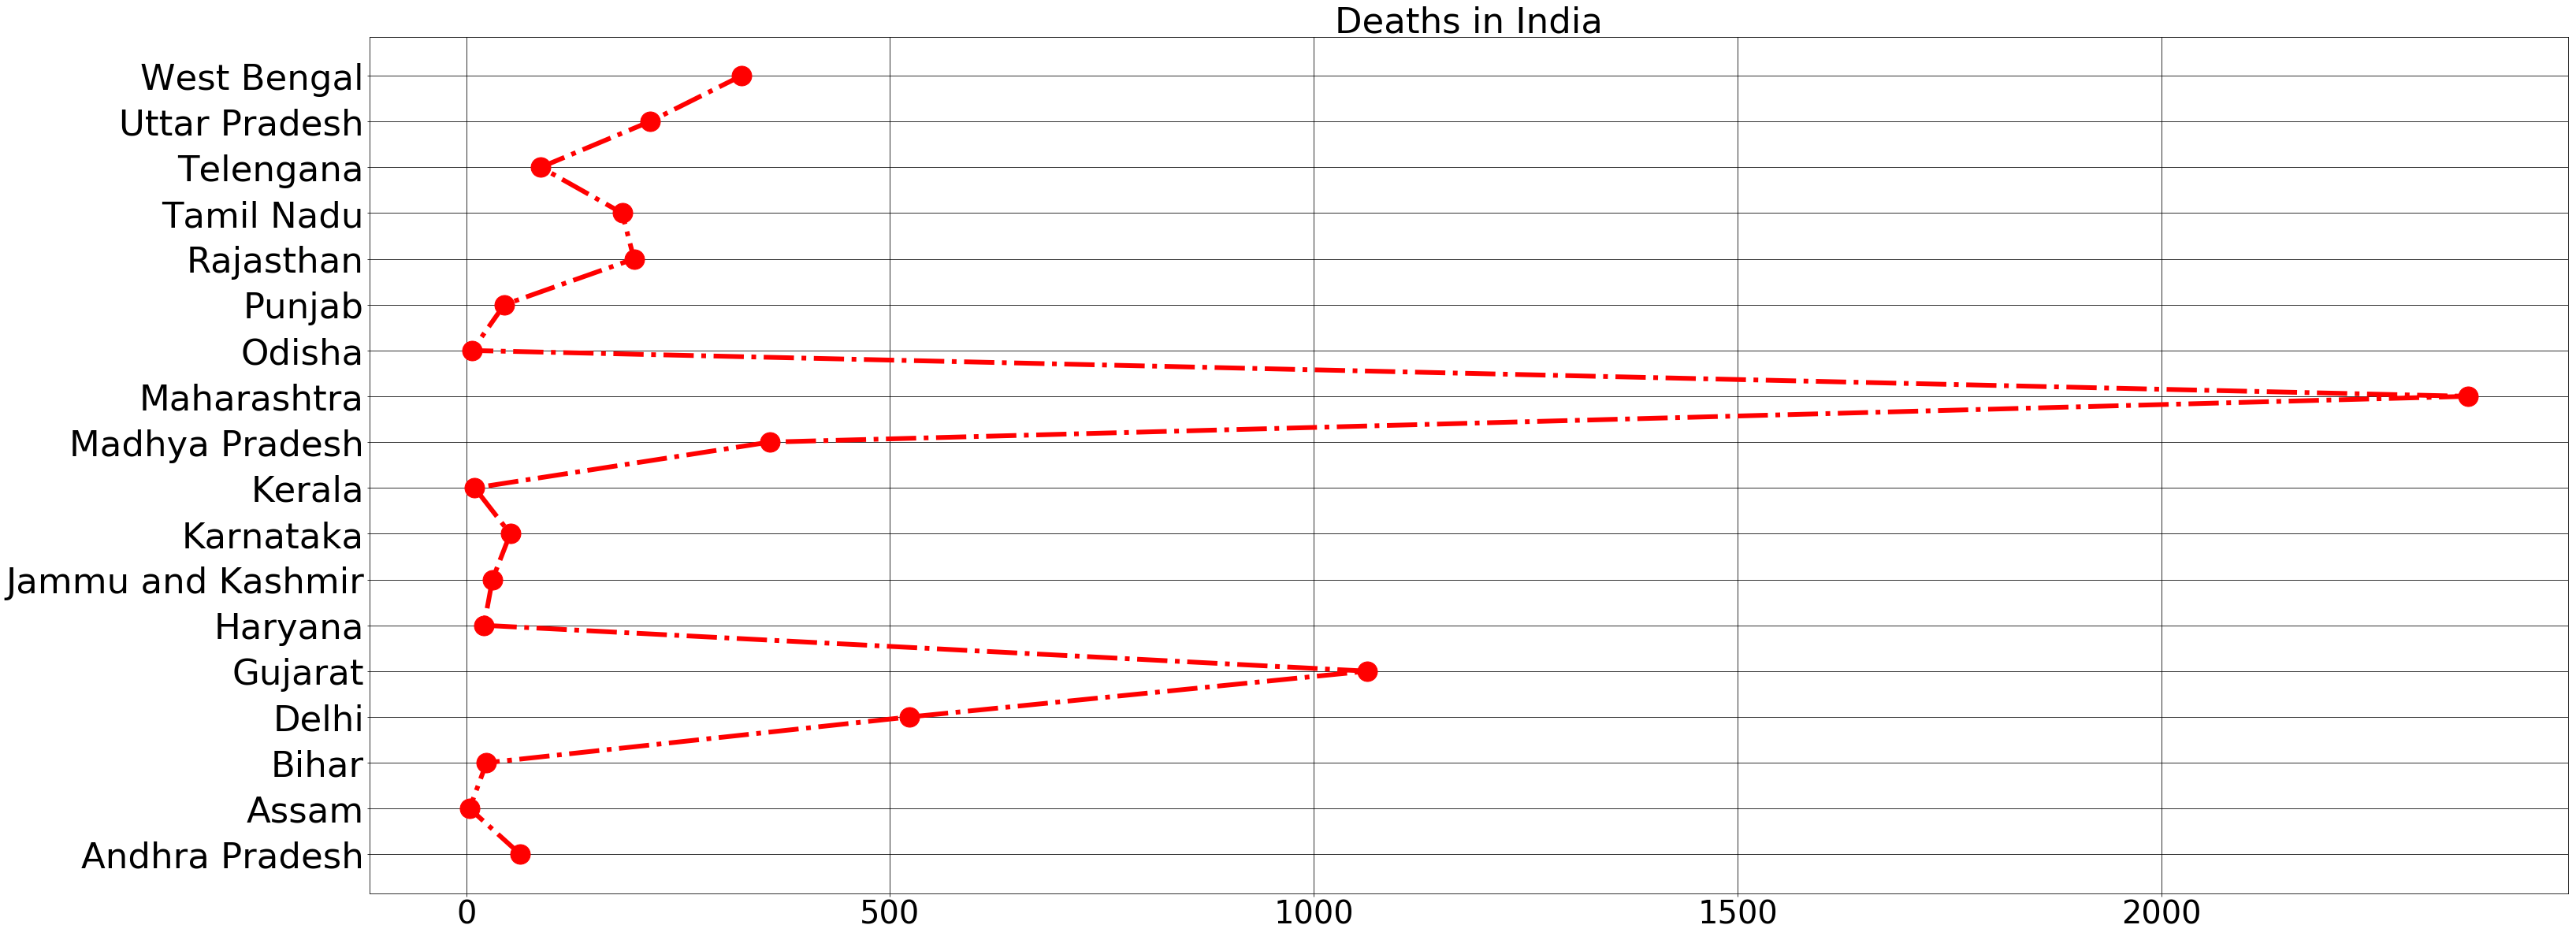

In [47]:
plt.figure(figsize=(50,20))
plt.title("Deaths in India",fontsize=45)
plt.plot(df_current_ava['Death'],df_current_ava['Name of State / UT'],"ro-.",linewidth = 6,markersize = 25)
plt.xticks(fontsize=40)
plt.yticks(fontsize=45)
plt.grid(color="k")

Cured in states

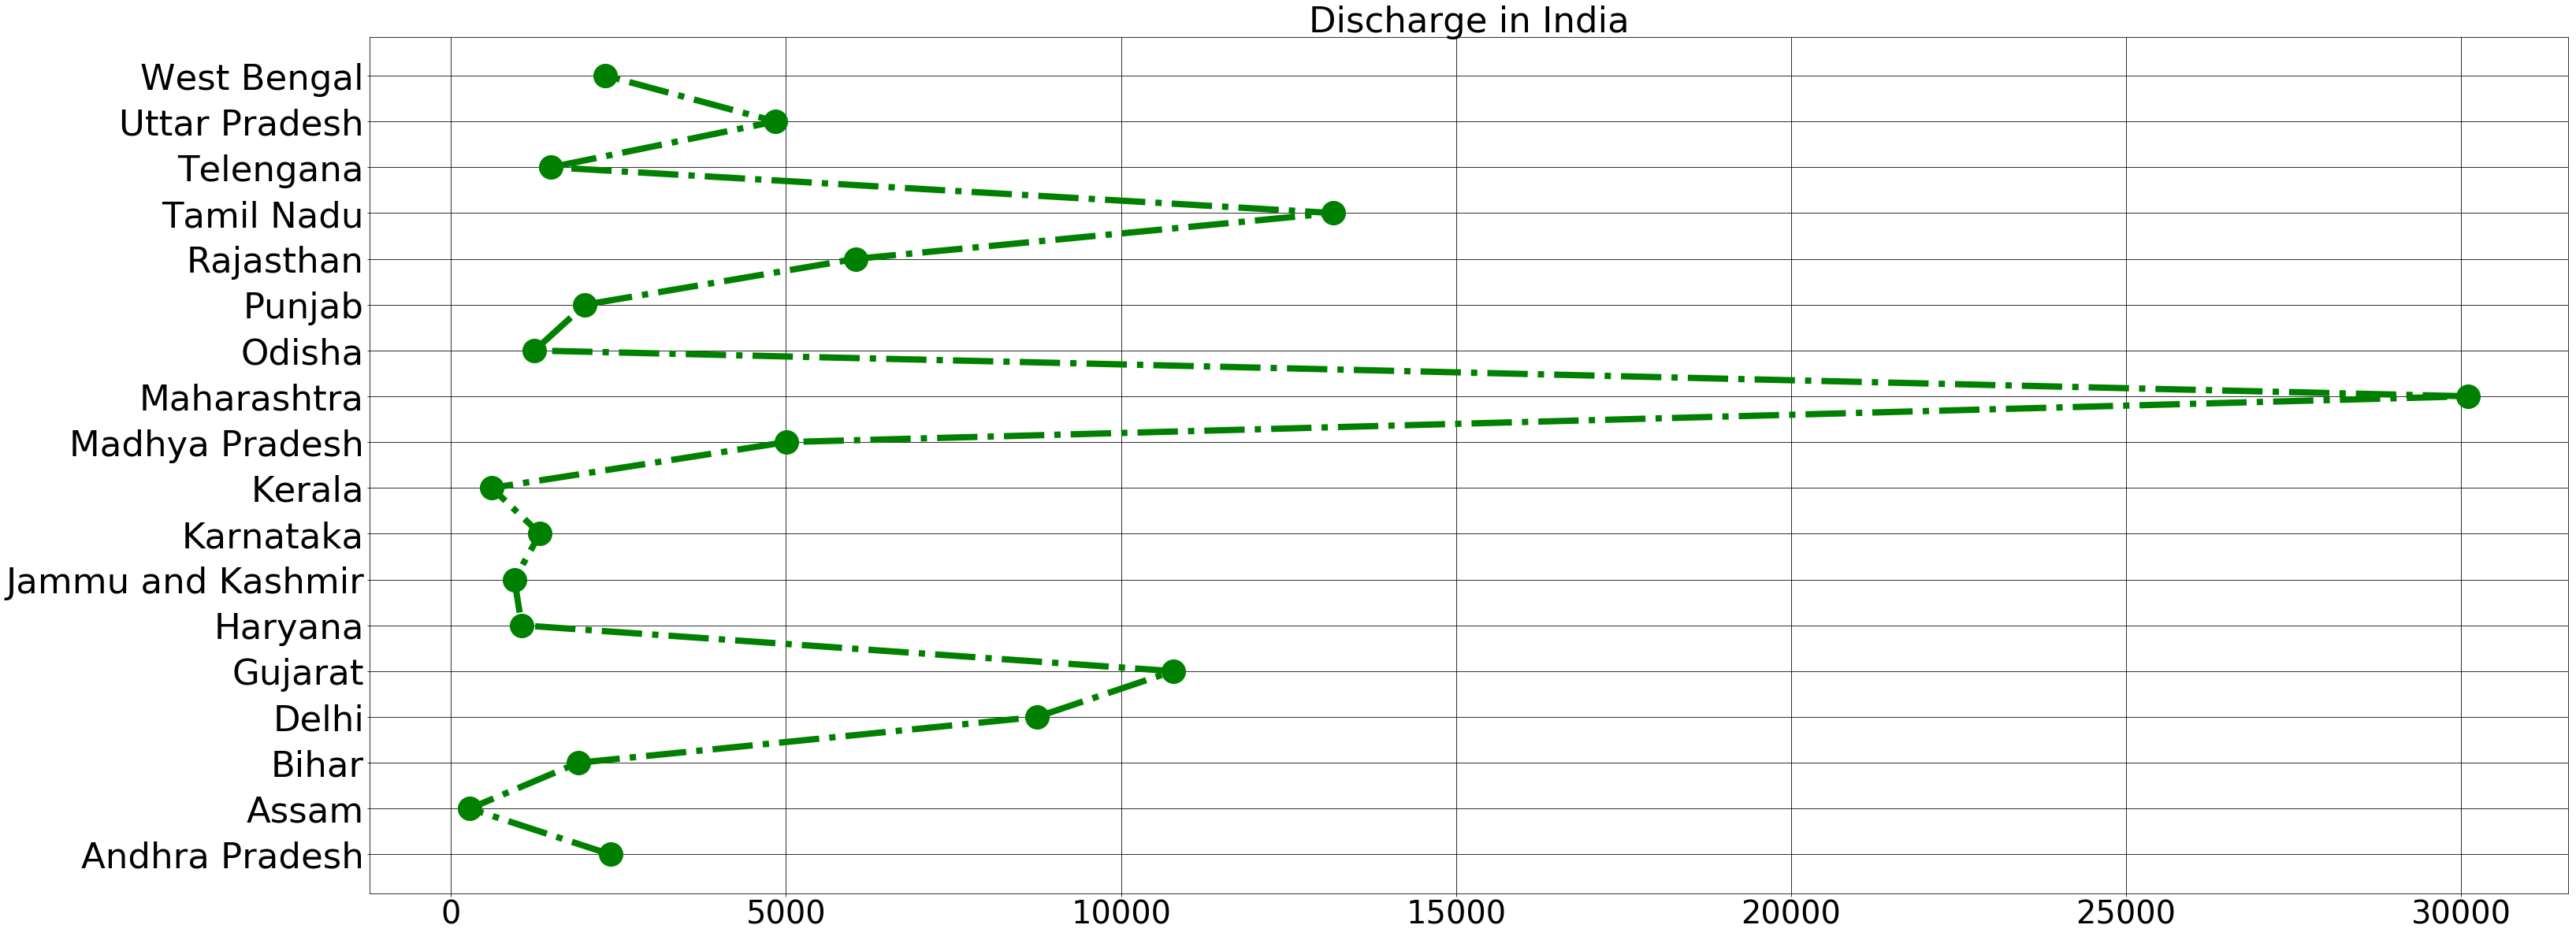

In [49]:
plt.figure(figsize=(50,20))
plt.title("Discharge in India",fontsize=45)
plt.plot(df_current_ava['Cured/Discharged/Migrated*'],df_current_ava['Name of State / UT'],"go-.",linewidth = 8,markersize = 30)
plt.xticks(fontsize=40)
plt.yticks(fontsize=45)
plt.grid(color="k")

Death Percentage in India's States

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 <a list of 18 Text xticklabel objects>)

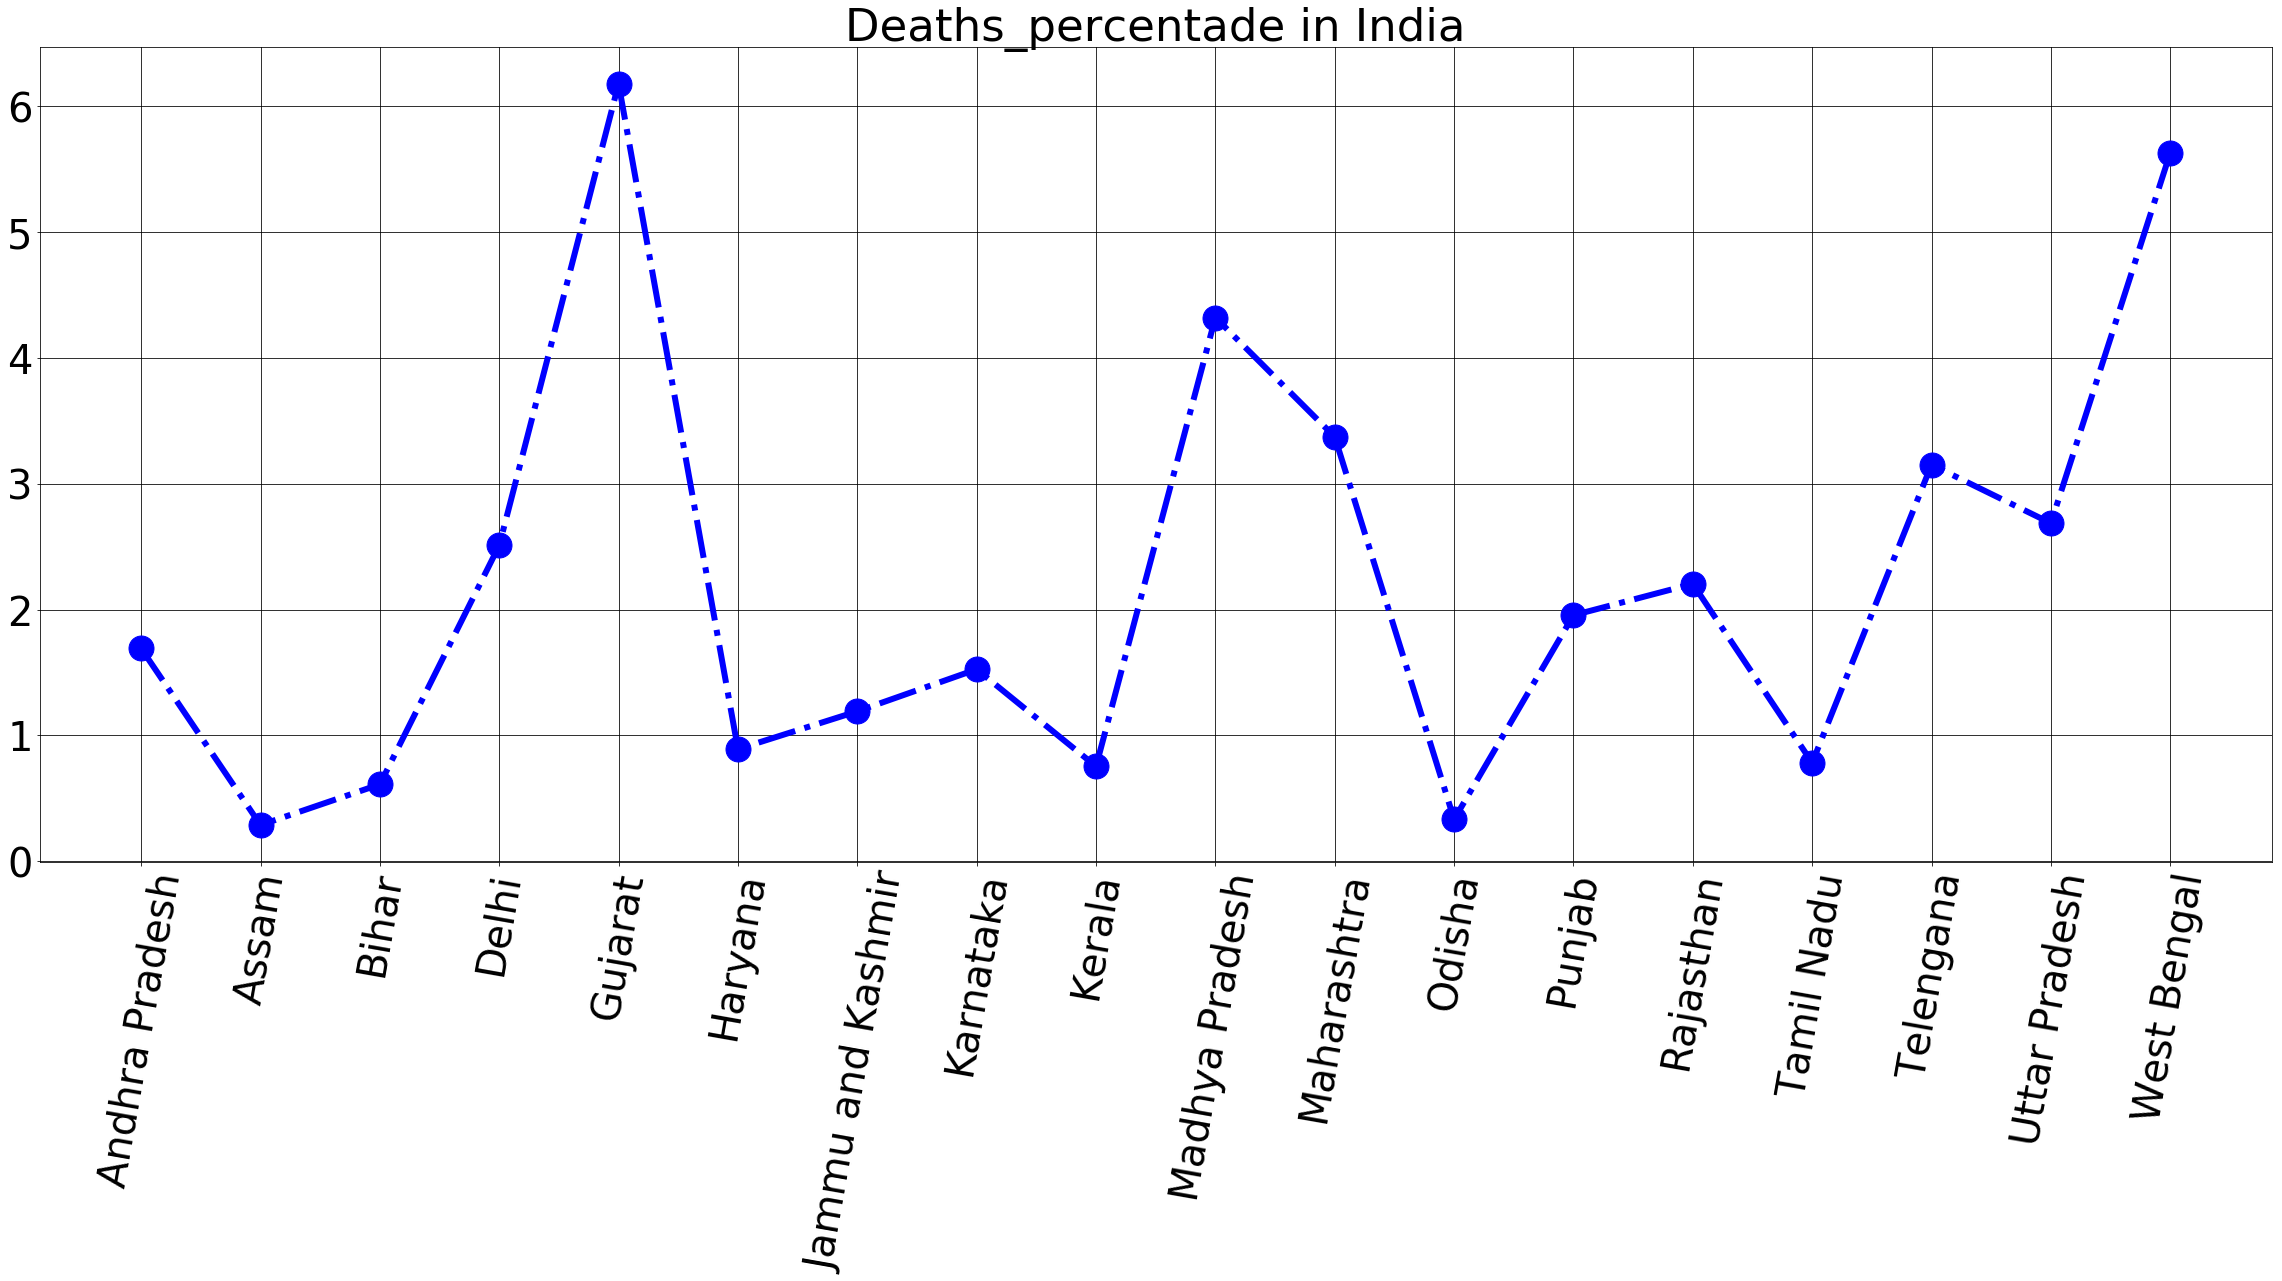

In [54]:
plt.figure(figsize=(40,15))
plt.title("Deaths_percentade in India",fontsize=45)
plt.plot(df_current_ava['Name of State / UT'],df_current_ava['Death_percentage'],"bo-.",linewidth = 6,markersize = 25)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.grid(color="k")
plt.xticks(rotation=80)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 <a list of 18 Text xticklabel objects>)

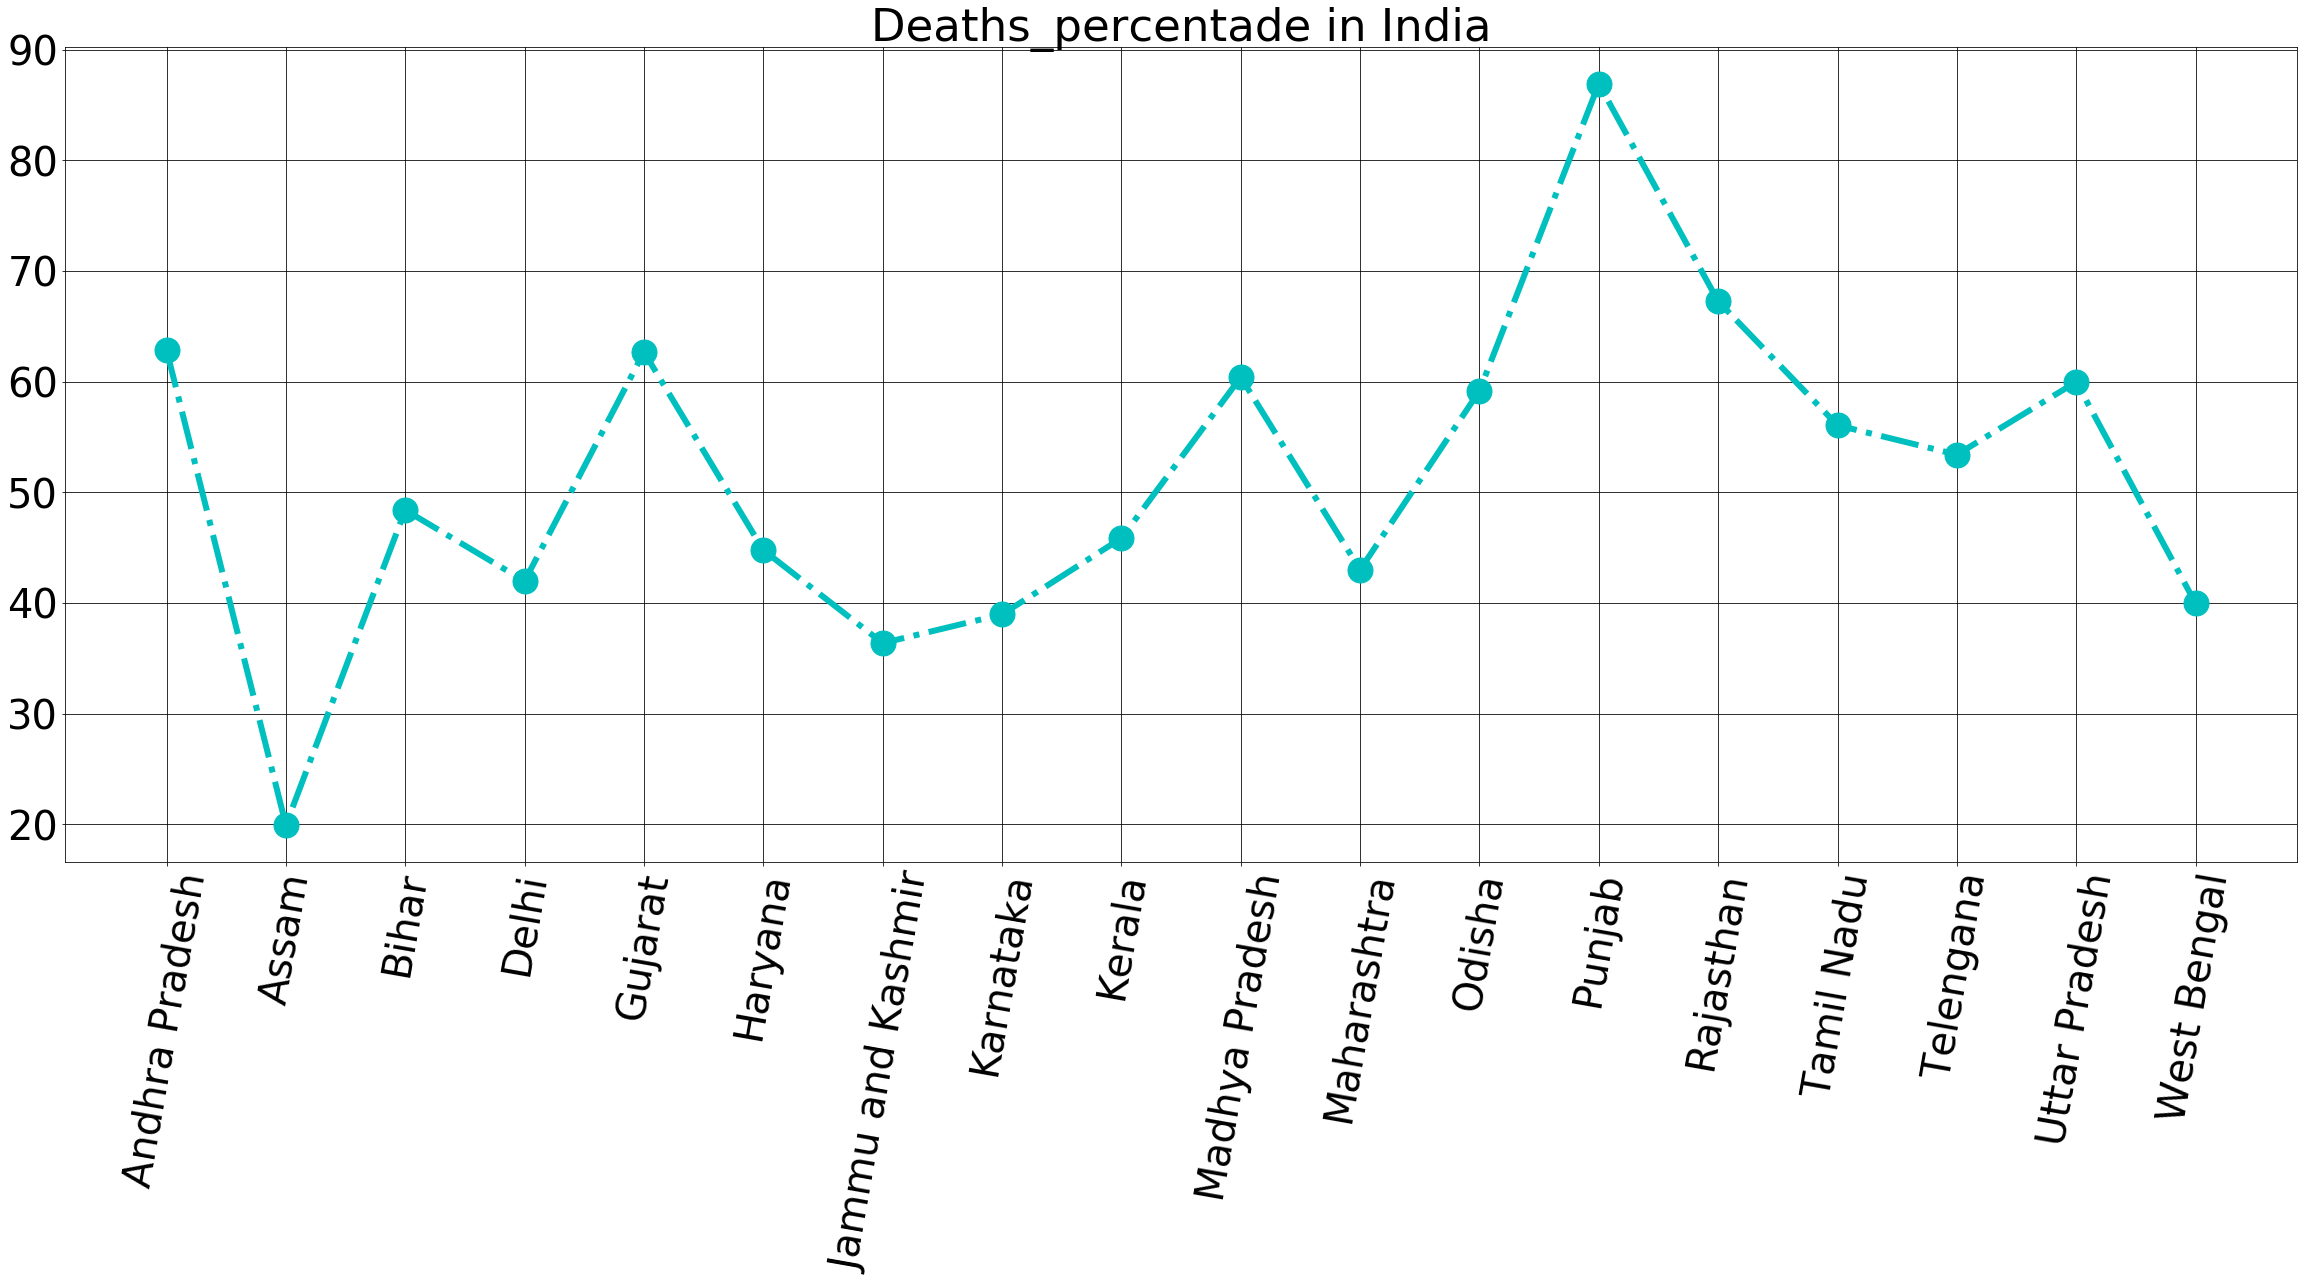

In [56]:
plt.figure(figsize=(40,15))
plt.title("Deaths_percentade in India",fontsize=45)
plt.plot(df_current_ava['Name of State / UT'],df_current_ava['Cured_percentage'],"co-.",linewidth = 6,markersize = 25)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.grid(color="k")
plt.xticks(rotation=80)

Here we can seen that Cured patients is more then death once

# INDIA COvid-19


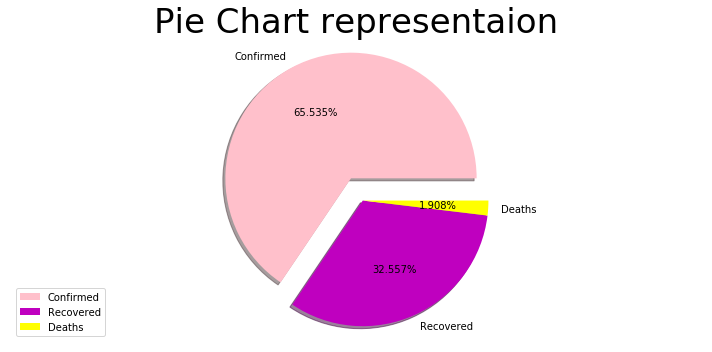

In [57]:
plt.figure(figsize=(10,5))
labels=['Confirmed','Recovered','Deaths']
colors=['pink','m','yellow']
explode=[0.2,0,0]
values=[Total_cases_in_India,Total_cured_in_India,Total_deaths_in_India]

plt.title("Pie Chart representaion",fontsize=34)
plt.pie(values,labels=labels,colors=colors,explode=explode,autopct='%0.3f%%',shadow=True)
plt.legend(['Confirmed','Recovered','Deaths'] , loc=3)
plt.axis('equal')
plt.tight_layout()
plt.show()